In [1]:
# Import libraries necessary for this project
import missingno as msno
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import norm, skew 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Allows the use of display() for DataFrames
from IPython.display import display 

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns',100)
pd.set_option('max_rows',100000)

# 데이터 숫자 소숫점 표시
pd.options.display.float_format = '{:.2f}'.format 

In [84]:
# read_csv
raw_data = pd.read_csv('vehicles.csv')

In [85]:
# 제외 항목 제거
raw_data.drop(['url', 'region', 'region_url', 'model', 'condition', 'vin', 'size', 
               'image_url', 'description', 'county', 'lat', 'long'], axis=1, inplace=True)
# 결측 행 제거
raw_data = raw_data.dropna(axis=0)

In [93]:
# price : $100 이하, $100만 이상 제거
raw_data = raw_data[(raw_data['price'] > 100) & (raw_data['price'] <= 1000000)]

# price : 1 ~ 9까지 중복된 숫자 제거
price_duple = raw_data[raw_data['price']
                       .isin([1, 11, 111, 1111, 11111, 111111, 1111111, 11111111, 111111111, 
                              2, 22, 222, 2222, 22222, 222222, 2222222, 22222222, 222222222, 
                              3, 33, 333, 3333, 33333, 333333, 3333333, 33333333, 333333333, 
                              4, 44, 444, 4444, 44444, 444444, 4444444, 44444444, 444444444, 
                              5, 55, 555, 5555, 55555, 555555, 5555555, 55555555, 555555555, 
                              6, 66, 666, 6666, 66666, 666666, 6666666, 66666666, 666666666, 
                              7, 77, 777, 7777, 77777, 777777, 7777777, 77777777, 777777777, 
                              8, 88, 888, 8888, 88888, 888888, 8888888, 88888888, 888888888, 
                              9, 99, 999, 9999, 99999, 999999, 9999999, 99999999, 999999999])].index
raw_data.drop(price_duple, inplace=True)

# price : 1 ~ 9까지 연속된 숫자 제거
price_iter = raw_data[raw_data['price']
                      .isin([12, 123, 1234, 12345, 123456, 1234567, 12345678, 123456789,  
                             23, 234, 2345, 23456, 234567, 2345678, 23456789, 
                             34, 345, 3456, 34567, 345678, 3456789, 
                             45, 456, 4567, 45678, 456789, 
                             56, 567, 5678, 56789, 
                             67, 678, 6789, 
                             78, 789, 
                             89, 
                             90,
                             98, 987, 9876, 98765, 987654, 9876543, 98765432, 987654321, 
                             87, 876, 8765, 87654, 876543, 8765432, 87654321, 
                             76, 765, 7654, 76543, 765432, 7654321, 
                             65, 654, 6543, 65432, 654321, 
                             54, 543, 5432, 54321, 
                             43, 432, 4321, 
                             32, 321, 
                             21])].index
raw_data.drop(price_iter, inplace=True)

# year : 0값, 2020년, 2021년 데이터 제거
raw_data = raw_data[(raw_data['year'] != 0) & (raw_data['year'] != 2020) & (raw_data['year'] != 2021)]


# odometer : 0값, 100이하, 100만 마일 이상 데이터 제거
raw_data = raw_data[(raw_data['odometer'] != 0) & (raw_data['odometer'] >= 100) & (raw_data['odometer'] <= 1000000)]

# 추가 전처리 : 기존 데이터 수 169914개 - 추가 전처리 데이터 수 11582개 + 1089개 = 157243개
# year : 연도별 등록 수 2000개 이하 제외 : 1917년 ~ 1999년까지 총 9759개
raw_data = raw_data[raw_data['year'] >= 2000]

# price : $ 5만 이상 제외 : 1089개
raw_data = raw_data[raw_data['price'] <= 50000]

In [94]:
len(raw_data)

159558

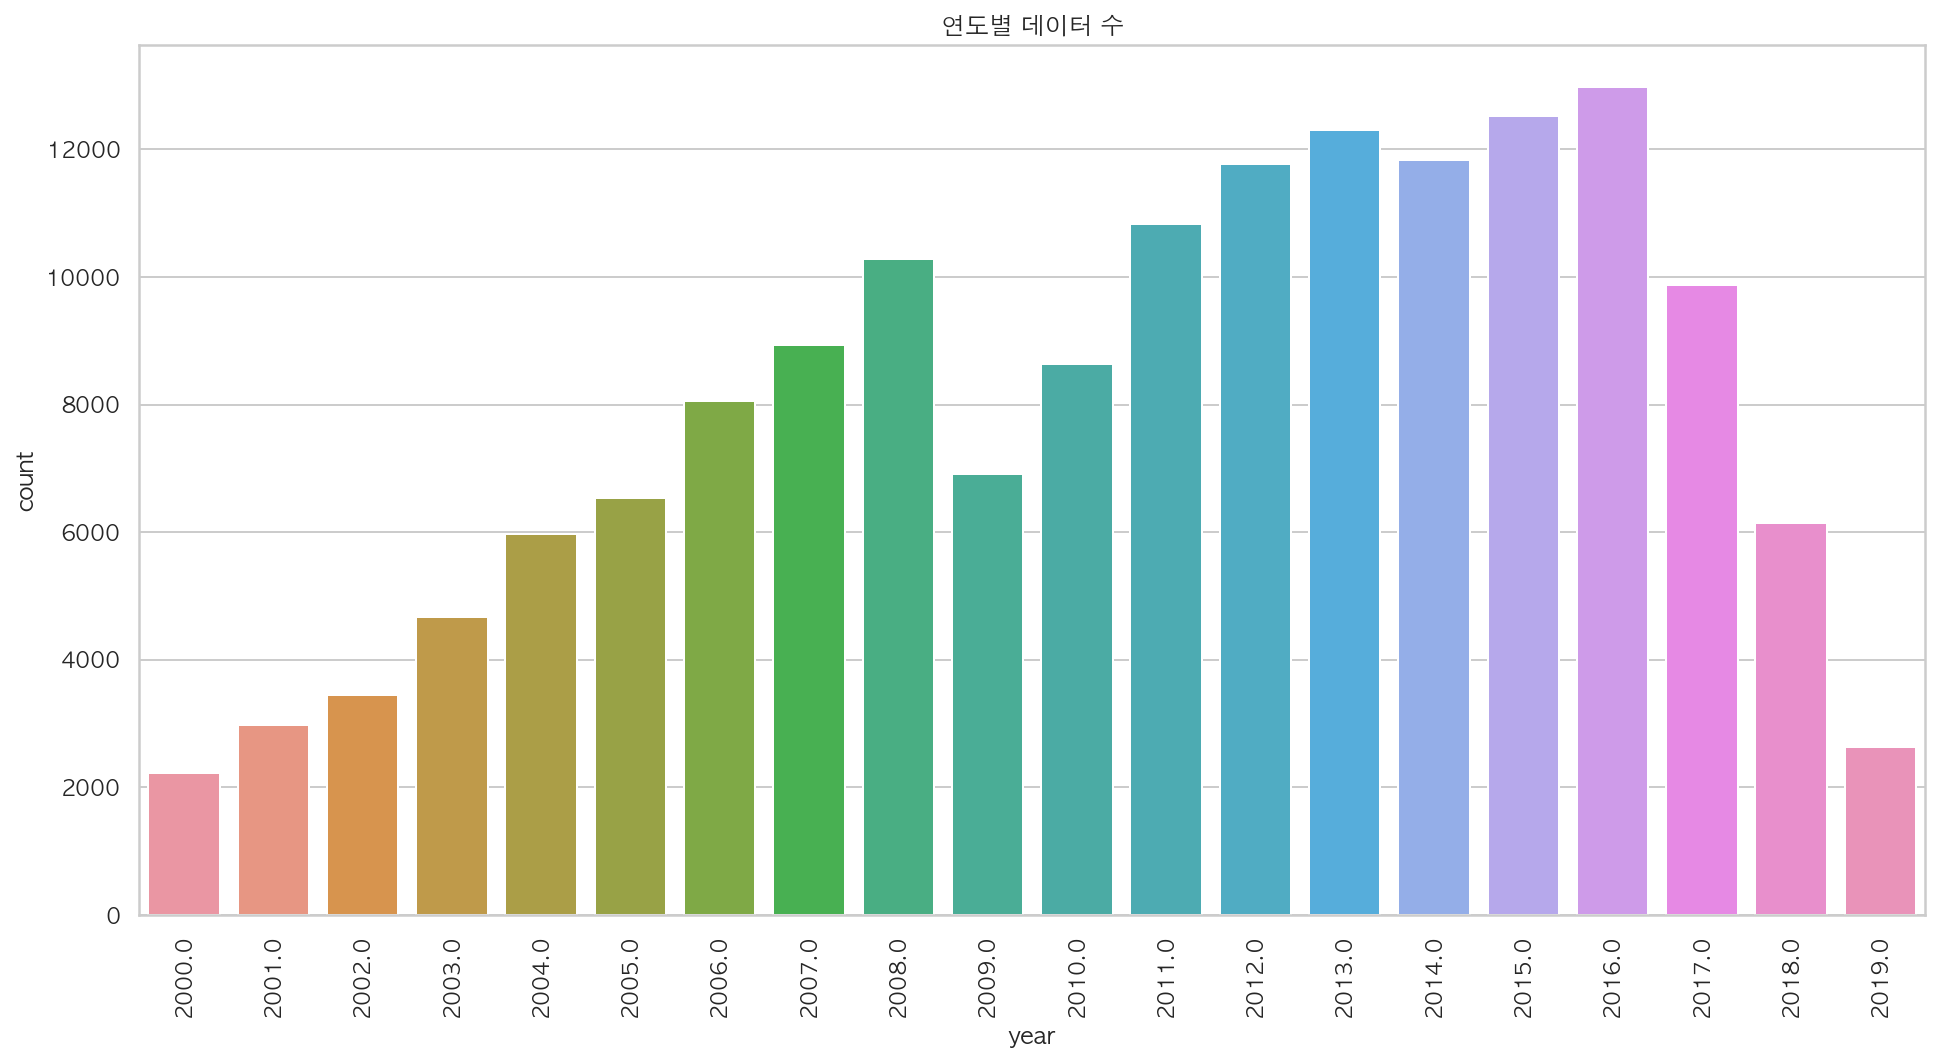

In [95]:
# year 데이터 그래프
plt.figure(figsize=(16,8))
ax = sns.countplot(x='year', data=raw_data)
plt.title('연도별 데이터 수')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
# plt.tight_layout()
plt.show()

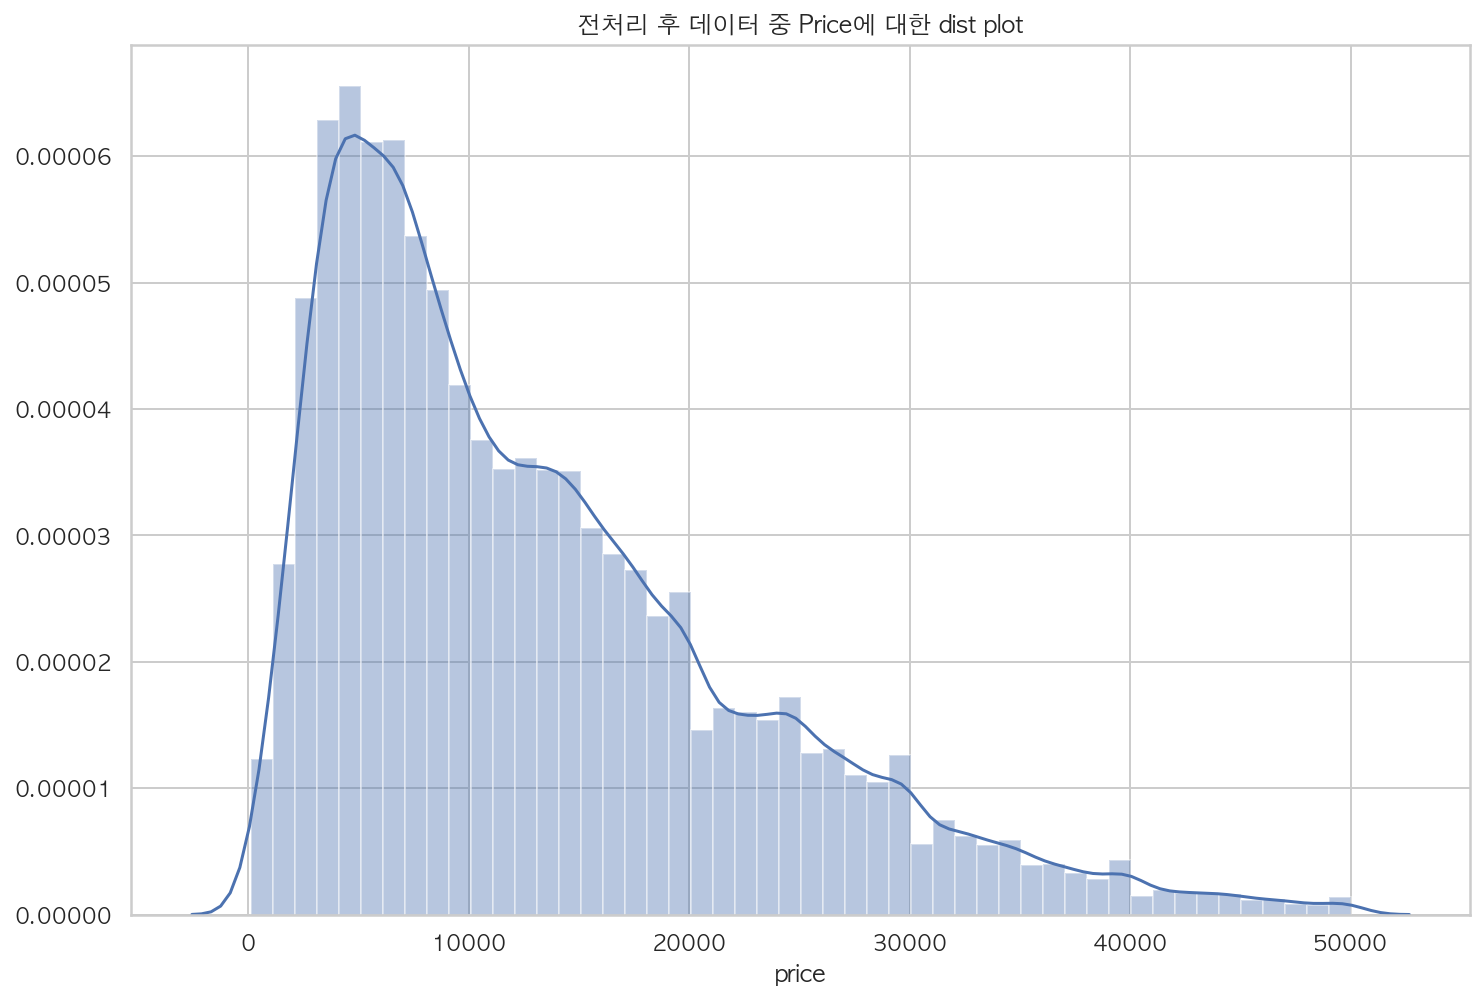

In [96]:
# price dist plot
plt.figure(figsize=(12,8))
sns.distplot(raw_data['price'], kde=True)
plt.title('전처리 후 데이터 중 Price에 대한 dist plot')
plt.show()

In [99]:
# 실수 OLS 분석: 가격, 연도(카테고리, 범주형 독립변수), 풀랭크 방식
# 결정계수 : 0.368, 회귀적 유용성 보통
# 연식 데이터가 숫자이므로 연속값으로 인식하지 않도록 C() 연산자를 사용
model = sm.OLS.from_formula("price ~ C(year) + 0", data=raw_data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     6116.
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:30:24   Log-Likelihood:            -1.6447e+06
No. Observations:              159558   AIC:                         3.289e+06
Df Residuals:                  159538   BIC:                         3.290e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(year)[2000.0]  4616.7654    153.877     

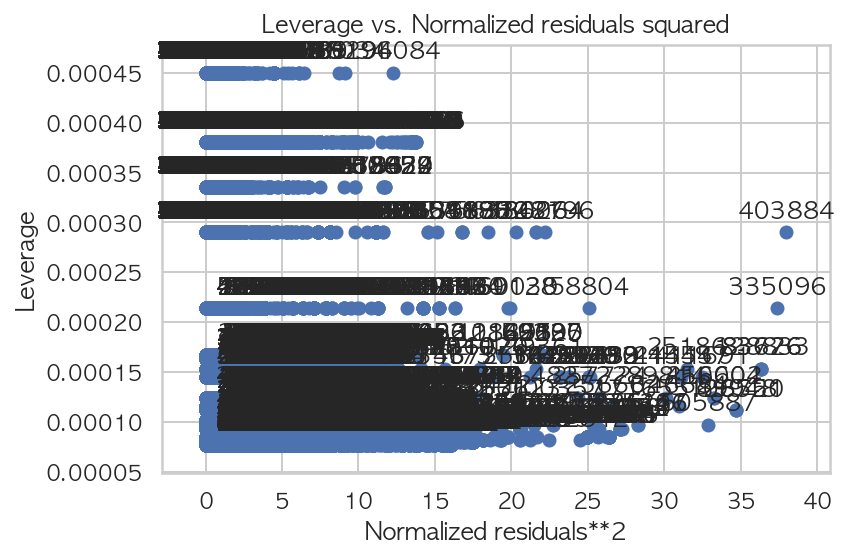

In [100]:
# cook's distance, price & year
# x축: 표준화 잔차의 제곱, y축: 레버리지 값
# plt.figure(figsize=(12,8))
sm.graphics.plot_leverage_resid2(result)
plt.tight_layout()
plt.show()

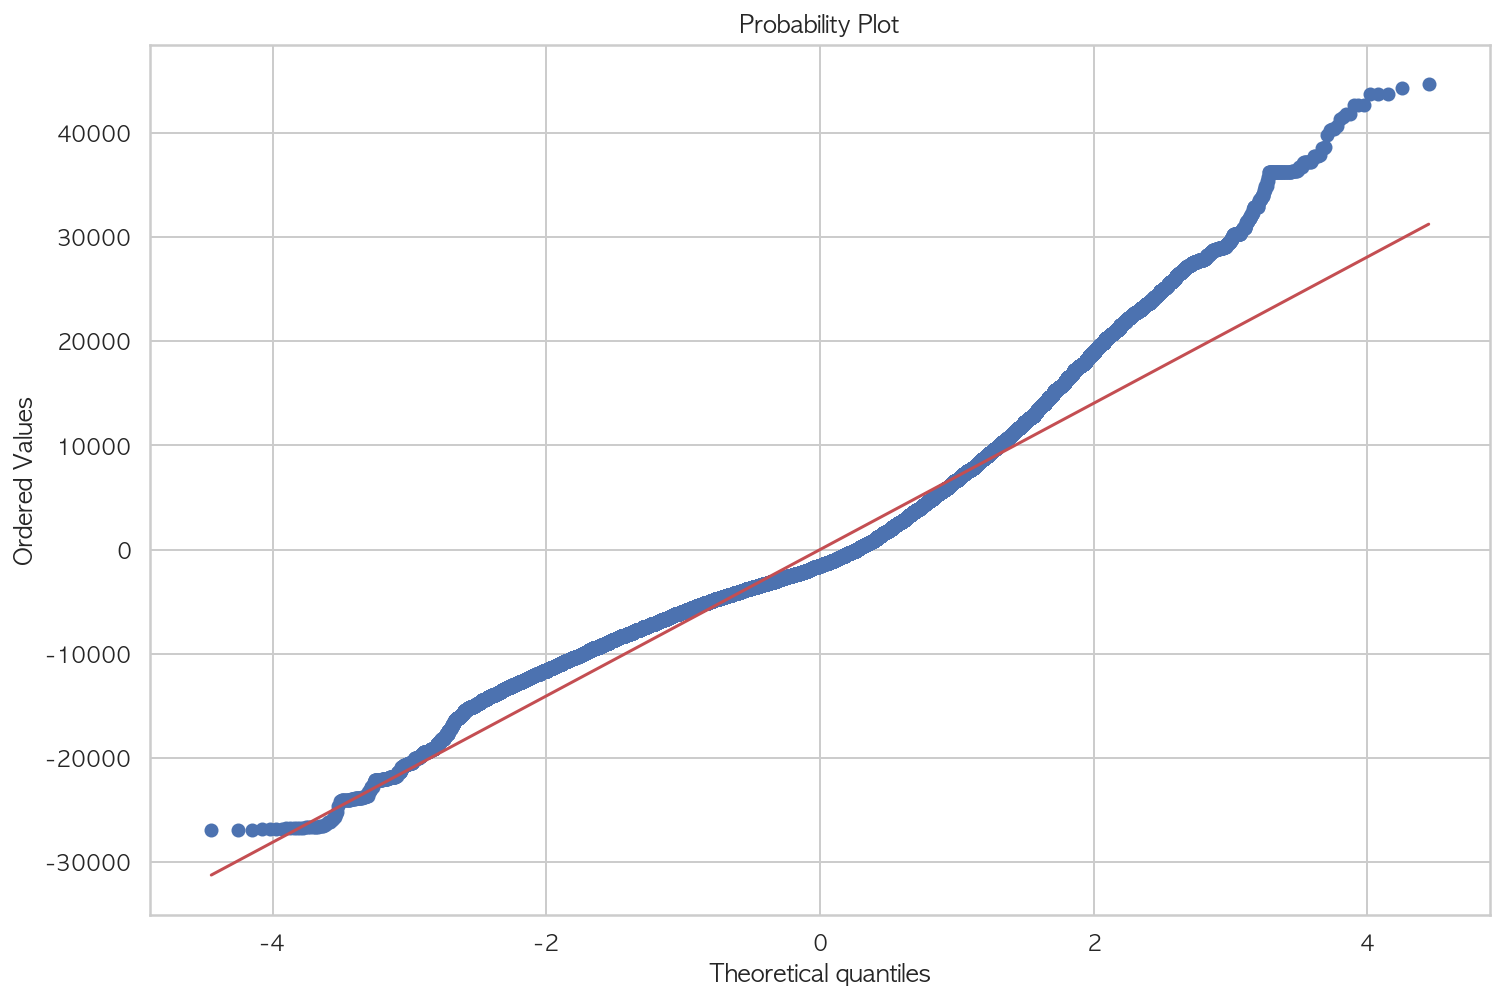

In [101]:
# QQ 플롯: 가격 & 연도
plt.figure(figsize=(12,8))
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [102]:
# 실수 OLS 분석: 가격, 주행거리
# 결정계수 : 0.078, 회귀적 유용성 낮음
model = sm.OLS.from_formula("price ~ odometer + 0", data=raw_data)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.310
Model:                            OLS   Adj. R-squared (uncentered):              0.310
Method:                 Least Squares   F-statistic:                          7.153e+04
Date:                Tue, 24 Mar 2020   Prob (F-statistic):                        0.00
Time:                        19:31:54   Log-Likelihood:                     -1.7444e+06
No. Observations:              159558   AIC:                                  3.489e+06
Df Residuals:                  159557   BIC:                                  3.489e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<Figure size 864x576 with 0 Axes>

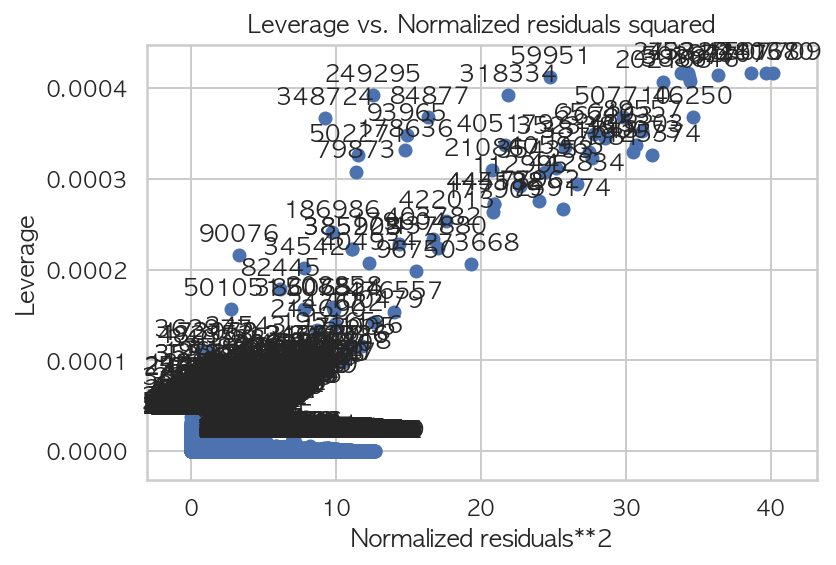

In [103]:
# cook's distance, price & odometer
# x축: 표준화 잔차의 제곱, y축: 레버리지 값
plt.figure(figsize=(12,8))
sm.graphics.plot_leverage_resid2(result)
plt.show()

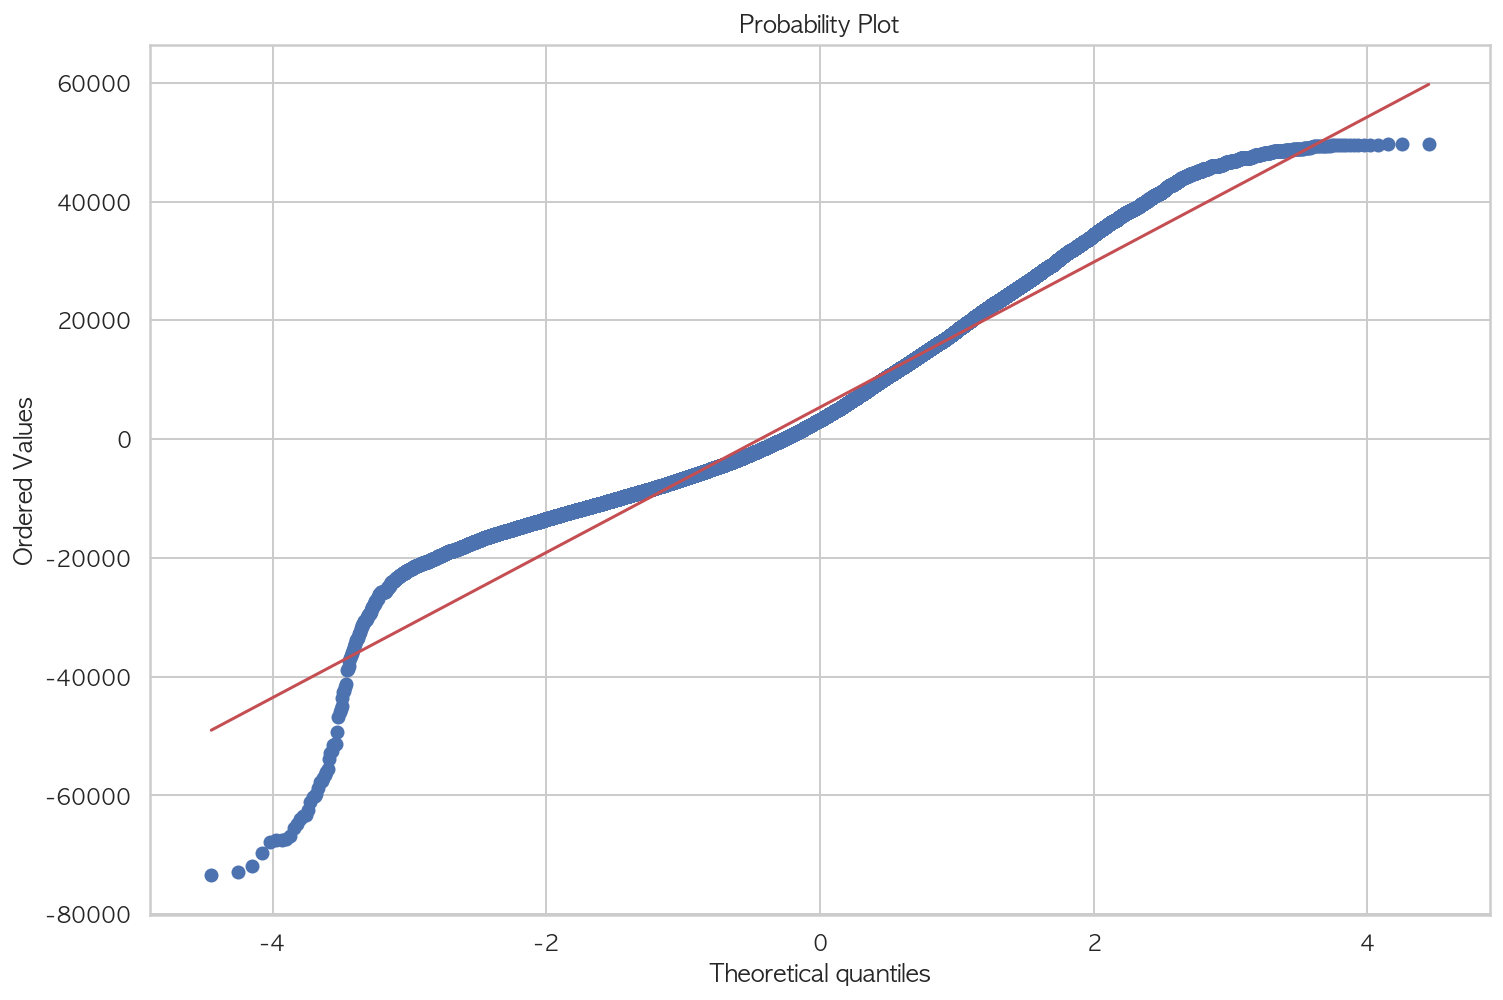

In [104]:
# QQ플롯: 가격 & 주행거리
plt.figure(figsize=(12,8))
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [105]:
# 스케일링
model = sm.OLS.from_formula("scale(price) ~ C(year) + C(manufacturer) \
+ C(cylinders) + C(fuel) + scale(odometer) + C(title_status) + C(transmission) \
+ C(drive) + C(type) + C(paint_color) + C(state) + 0", data=raw_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           scale(price)   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     3618.
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:32:38   Log-Likelihood:            -1.0770e+05
No. Observations:              159558   AIC:                         2.157e+05
Df Residuals:                  159406   BIC:                         2.172e+05
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
C(ye